In [18]:
# Import Required Libraries and warnings

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras

! pip install keras_tuner

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# metrics to validate
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing Data

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
y_train[0]

np.uint8(5)

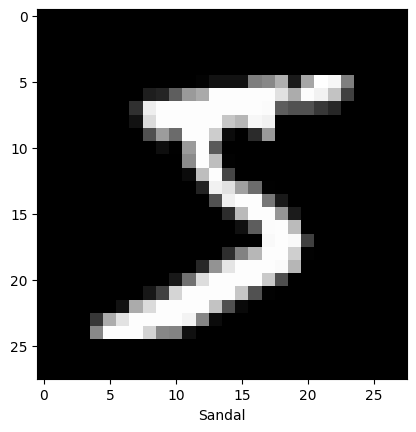

In [6]:
# display the first image
plt.imshow(x_train[0], cmap='grey')
plt.xlabel(classes[int(y_train[0])])
plt.show()

In [7]:
# dimension of the data
print(x_train.ndim)
print(x_test.ndim)

# shape of the image
print(x_train.shape)
print(x_test.shape)

3
3
(60000, 28, 28)
(10000, 28, 28)


In [8]:
# reshaping the data into 4 dimensions - [# of images, # rows, # cols, # layers]

x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [9]:
# Hyer Model

def hyper_model(hp):
  model=Sequential(
      [
          Conv2D(filters = hp.Int('conv_1_filter', min_value=16, max_value=128, step=8),      # no.of.filters
               kernel_size = hp.Choice('conv_1_kernel', values=[3,4,5]),                    # filter size
               activation = 'relu',
               input_shape = (28, 28, 1)),
        Conv2D(filters = hp.Int('conv_2_filter', min_value=8, max_value=64, step=4),        # no.of.filters
               kernel_size = hp.Choice('conv_2_kernel', values=[3,4,5]),                    # filter size
               activation = 'relu'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(units=hp.Int('dense_1_units',
                            min_value=32, max_value=256, step=4),
              activation='relu'),
        Dense(units=hp.Int('dense_2_units',
                            min_value=32, max_value=128, step=4),
              activation='relu'),
        Dense(10, activation='softmax')
      ]
  )
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model

In [10]:
tuner_output = RandomSearch(hyper_model,
                            objective='val_accuracy',
                            max_trials=5,
                            project_name='Mnist Optimization')

In [11]:
tuner_output.search(x_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Trial 5 Complete [00h 01m 21s]
val_accuracy: 0.987583339214325

Best val_accuracy So Far: 0.987583339214325
Total elapsed time: 00h 07m 10s


In [12]:
# Extracting the best hyperparameters out of all search
final_model = tuner_output.get_best_models(num_models=1)[0]

# best model summary
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 56)     │           952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 32)     │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 92)             │       356,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,206 (1.45 MB)

 Trainable params: 379,206 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# fitting the data onto the final model

final_model.fit(x_train, y_train, epochs=15, initial_epoch=10, validation_split=0.2)

Epoch 11/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.9853 - val_loss: 0.0684
Epoch 12/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9983 - loss: 0.0047 - val_accuracy: 0.9872 - val_loss: 0.0628
Epoch 13/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9868 - val_loss: 0.0701
Epoch 14/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.9866 - val_loss: 0.0752
Epoch 15/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9865 - val_loss: 0.0706


In [14]:
# model evaluation
final_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9844 - loss: 0.0718


[0.06055070832371712, 0.9866999983787537]

In [15]:
# model predictions
y_pred = final_model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [16]:
# index number of the predicted class based on the highest probability
y_class = np.array([np.argmax(ele) for ele in y_pred])

In [19]:
# printing the first five outputs
print('The actual label for the first 5 images:', y_test[0:5])
print('The predicted label for the first 5 images:', y_class[0:5])

The actual label for the first 5 images: [7 2 1 0 4]
The predicted label for the first 5 images: [7 2 1 0 4]


In [20]:
# function to validate a random image

def validate_rdm_img():
    rdm_img = random.randint(0, len(x_test))
    plt.imshow(x_test[rdm_img], cmap='grey')
    plt.show()

    print('Actual Image is:', classes[y_test[rdm_img]])
    print('Predicted Image is:', classes[y_class[rdm_img]])
    print('Prediction Proababiity is:', round(y_pred[rdm_img][y_class[rdm_img]]*100, 2), '%')

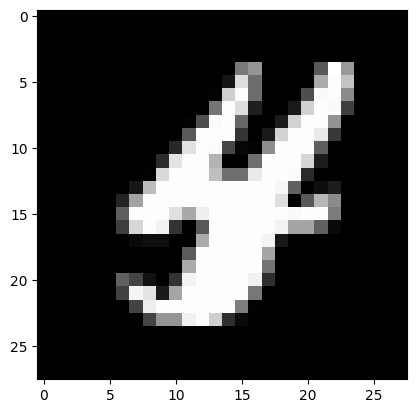

Actual Image is: Coat
Predicted Image is: Coat
Prediction Proababiity is: 100.0 %


In [23]:
# function call
validate_rdm_img()

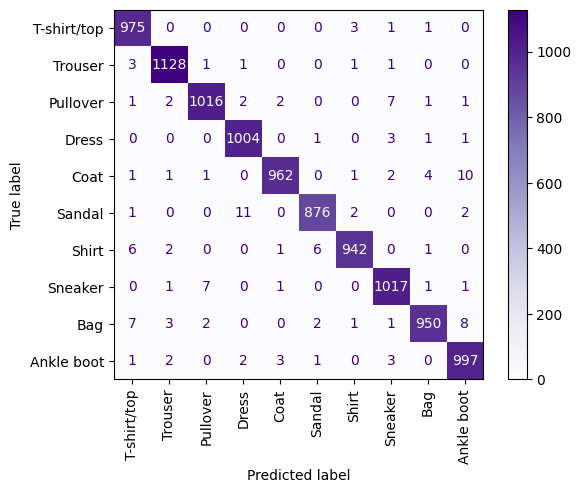

In [24]:
# validation metrics
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_class, display_labels=classes, xticks_rotation='vertical', cmap='Purples')

In [25]:
# classification report
report = classification_report(y_test, y_class, target_names=classes)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.98      0.99      0.99       980
     Trouser       0.99      0.99      0.99      1135
    Pullover       0.99      0.98      0.99      1032
       Dress       0.98      0.99      0.99      1010
        Coat       0.99      0.98      0.99       982
      Sandal       0.99      0.98      0.99       892
       Shirt       0.99      0.98      0.99       958
     Sneaker       0.98      0.99      0.99      1028
         Bag       0.99      0.98      0.98       974
  Ankle boot       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

